In [1]:
from conllu import parse
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from statistics import median

Using TensorFlow backend.


In [3]:
train_data_file = open("ru_syntagrus-ud-train.conllu", "r", encoding="utf-8").read()
test_data_file = open("ru_syntagrus-ud-test.conllu", "r", encoding="utf-8").read()

Русский язык явл-ся флективным, то есть в нём словоизменительное и словообразовательное значение выражается преимущественно флексией, а также синтетическим (преобладают синтетические формы выражения грамматических значений). Ему также присуща фузия, при которой на стыке морфем происходят изменения, чередования, сюда же относится и многозначность морфем. С точки зрения синтаксиса русский язык явл-ся языком номинативного строя, т.е. в нём хорошо развиты субъектно-объектные отношения. С точки зрения фонетики русский язык – язык консонантного типа.

## Дескриптивная статистика для тренировочной выборки

In [4]:
# количество примеров в тренировочной выборке было сокращено до 7 тыс

train_sentences = parse(train_data_file)[:7000]
print('Количество предложений в тренировочной выборке:', len(train_sentences))

Количество предложений в тренировочной выборке: 7000


In [5]:
all_train_words = set()
for sentence in train_sentences:
    all_train_words |= set(tokenlist["form"].lower() for tokenlist in sentence)
    
print('Количество уникальных токенов в тренировочной выборке:', len(all_train_words))

Количество уникальных токенов в тренировочной выборке: 27283


In [6]:
all_POStags = set()
for sentence in train_sentences:
    all_POStags |= set(tokenlist["upostag"] for tokenlist in sentence)
    
print('Количество уникальных PoS-тегов в тренировочной выборке:', len(all_POStags))

Количество уникальных PoS-тегов в тренировочной выборке: 18


In [7]:
sent_lengths = []
for sentence in train_sentences:
    sent_lengths.append(len([tokenlist["form"] for tokenlist in sentence]))
    
print('Максимальное число токенов в предложении:', max(sent_lengths))
print('Минимальное число токенов в предложении:', min(sent_lengths))

Максимальное число токенов в предложении: 194
Минимальное число токенов в предложении: 2


In [8]:
print('Математическое ожидание числа слов в предложении:', sum(sent_lengths)/len(sent_lengths))

Математическое ожидание числа слов в предложении: 17.171142857142858


In [9]:
print('Медиана числа слов в предложении:', median(sent_lengths))

Медиана числа слов в предложении: 15.0


## Дескриптивная статистика для тестовой выборки

In [20]:
# количество примеров в тестовой выборке было сокращено до 2 тыс

test_sentences = parse(test_data_file)[:2000]
print('Количество предложений в тестовой выборке:', len(test_sentences))

Количество предложений в тестовой выборке: 2000


In [11]:
all_test_words = set()
for sentence in test_sentences:
    all_test_words |= set(tokenlist["form"].lower() for tokenlist in sentence)
    
print('Количество уникальных токенов в тестовой выборке:', len(all_test_words))

Количество уникальных токенов в тестовой выборке: 10069


In [12]:
all_POStags = set()
for sentence in test_sentences:
    all_POStags |= set(tokenlist["upostag"] for tokenlist in sentence)
    
print('Количество уникальных PoS-тегов в тестовой выборке:', len(all_POStags))

Количество уникальных PoS-тегов в тестовой выборке: 18


In [13]:
test_sent_lengths = []
for sentence in test_sentences:
    test_sent_lengths.append(len([tokenlist["form"] for tokenlist in sentence]))
    
print('Максимальное число токенов в предложении:', max(test_sent_lengths))
print('Минимальное число токенов в предложении:', min(test_sent_lengths))

Максимальное число токенов в предложении: 68
Минимальное число токенов в предложении: 2


In [14]:
print('Математическое ожидание числа слов в предложении:', sum(test_sent_lengths)/len(test_sent_lengths))

Математическое ожидание числа слов в предложении: 16.5545


In [15]:
print('Медиана числа слов в предложении:', median(test_sent_lengths))

Медиана числа слов в предложении: 14.0


_____________________________________

In [16]:
print('Доля новых слов в тестовой выборке:', len(all_test_words - all_train_words)/len(all_test_words))

Доля новых слов в тестовой выборке: 0.5093852418313636


## Подготовка данных

### Тренировочные данные

In [17]:
# Для каждого предложения выборки создаём 2 списка: 
# в первом - слова предложения, во втором - соответствующие словам теги частеречной разметки

train_word_lists = []
train_POStag_lists = []

for train_sentence in train_sentences:
    train_word_lists.append([word_info['form'].lower() for word_info in train_sentence])
    train_POStag_lists.append([word_info['upostag'] for word_info in train_sentence])

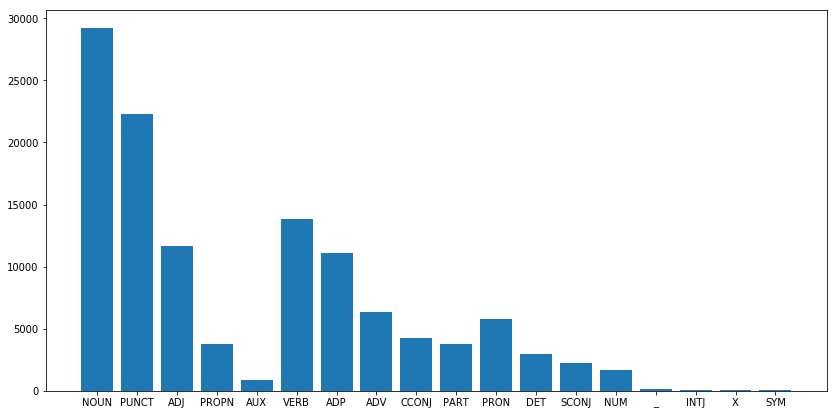

In [18]:
# распределение POS-тегов в тренировочной выборке

tag_distr = dict(Counter([tag for sent in train_POStag_lists for tag in sent]))
plt.rcParams['figure.figsize'] = 14, 7
plt.bar(list(tag_distr.keys()), list(tag_distr.values()), align='center')
plt.show()

In [78]:
MAX_SEQLEN = 120
S_MAX_FEATURES = len(all_train_words)-2
T_MAX_FEATURES = 18

In [79]:
# функция для создания словаря соответствия между словами (тегами) и их индексами в порядке увеличения количества слов (тегов) в корпусе

def make_indexed_dict(sentences, MAX_FEATURES, mark):
    if mark == 'word':
        word_freqs = Counter([word['form'].lower() for sent in sentences for word in sent])
        words_indexed = {word[0]:i+2 for i, word in enumerate(word_freqs.most_common(MAX_FEATURES))}
        words_indexed['PAD'] = 0
        words_indexed['UNK'] = 1
    elif mark == 'POS':
        word_freqs = Counter([word['upostag'] for sent in sentences for word in sent])
        words_indexed = {word[0]:i for i, word in enumerate(word_freqs.most_common(MAX_FEATURES))}
    return words_indexed

In [80]:
train_words_indexed = make_indexed_dict(train_sentences, S_MAX_FEATURES, 'word')
train_indexes_words = dict((y,x) for x,y in train_words_indexed.items())
len(train_words_indexed)

27283

In [81]:
train_POStags_indexed = make_indexed_dict(train_sentences, T_MAX_FEATURES, 'POS')
train_indexes_POStags = dict((y,x) for x,y in train_POStags_indexed.items())
train_POStags_indexed

{'NOUN': 0,
 'PUNCT': 1,
 'VERB': 2,
 'ADJ': 3,
 'ADP': 4,
 'ADV': 5,
 'PRON': 6,
 'CCONJ': 7,
 'PROPN': 8,
 'PART': 9,
 'DET': 10,
 'SCONJ': 11,
 'NUM': 12,
 'AUX': 13,
 '_': 14,
 'X': 15,
 'SYM': 16,
 'INTJ': 17}

In [82]:
# функция для кодирования слов (тегов) в предложениях через их индексы  

def make_word_vectors(word_lists, words_indexed):
    embed_lists = []
    for word_list in word_lists:
        embed_list = []
        for token in word_list:
            if token in words_indexed:
                embed_list.append(words_indexed[token])
            else:
                embed_list.append(1) # 1 - 'UNK'
        embed_lists.append(embed_list)
    return embed_lists

In [83]:
train_indexed_lists = make_word_vectors(train_word_lists, train_words_indexed)
train_indexed_lists

[[3928, 3],
 [842,
  2945,
  502,
  219,
  220,
  232,
  56,
  84,
  1609,
  2,
  9831,
  8,
  339,
  124,
  1610,
  2,
  9832,
  11,
  9833,
  23,
  503,
  5,
  478,
  69,
  1906,
  4,
  9834,
  3929,
  79,
  9835,
  7,
  1354,
  7,
  3],
 [4,
  3930,
  29,
  11,
  2345,
  5698,
  2346,
  2,
  6,
  2946,
  11,
  9836,
  3931,
  2,
  13,
  2946,
  5,
  11,
  1169,
  2,
  58,
  597,
  57,
  33,
  941,
  4,
  9837,
  9838,
  2,
  9,
  9839,
  942,
  1046,
  3],
 [108,
  1047,
  179,
  942,
  1046,
  9840,
  4,
  61,
  2,
  53,
  2347,
  115,
  5699,
  5,
  2947,
  5700,
  4,
  122,
  3],
 [9841, 74, 9842, 114, 2, 19, 9843, 3],
 [26, 1611, 598, 646, 9844, 2, 8, 1355, 6, 9845, 9846, 11, 2348, 9847, 3],
 [4,
  3932,
  9848,
  9849,
  5,
  5701,
  5702,
  21,
  9850,
  9851,
  5,
  47,
  21,
  78,
  2,
  53,
  9852,
  1170,
  1907,
  2,
  9853,
  22,
  1908,
  2,
  30,
  15,
  2,
  9854,
  2,
  278,
  1612,
  244,
  2948,
  5,
  5703,
  132,
  3],
 [1048, 3933, 9855, 2, 2949, 9856, 9857, 3],

In [84]:
train_POSembed_lists = make_word_vectors(train_POStag_lists, train_POStags_indexed)
train_POSembed_lists = [np_utils.to_categorical(POSsent, T_MAX_FEATURES) for POSsent in train_POSembed_lists]
train_POSembed_lists

[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


In [85]:
# для того, чтобы на вход сети поступали вектора одинаковой размерности, добавляем пустые значения (нули) 
# в вектора, размерность которых меньше maxlen

X = sequence.pad_sequences(train_indexed_lists, maxlen = 120)
X.shape

(7000, 120)

In [86]:
Y = sequence.pad_sequences(train_POSembed_lists, maxlen = 120)
Y.shape

(7000, 120, 18)

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5600, 120) (1400, 120) (5600, 120, 18) (1400, 120, 18)


### Тестовые данные

In [65]:
test_word_lists = []
test_POStag_lists = []

for test_sentence in test_sentences:
    test_word_lists.append([word_info['form'].lower() for word_info in test_sentence])
    test_POStag_lists.append([word_info['upostag'] for word_info in test_sentence])

In [97]:
len(test_POStag_lists)

2000

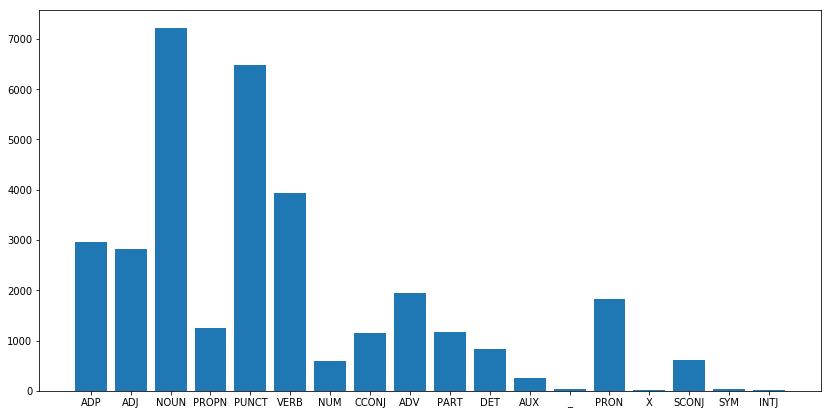

In [98]:
# распределение POS-тегов в тренировочной выборке

tag_distr = dict(Counter([tag for sent in test_POStag_lists for tag in sent]))
plt.rcParams['figure.figsize'] = 14, 7
plt.bar(list(tag_distr.keys()), list(tag_distr.values()), align='center')
plt.show()

In [99]:
test_words_indexed = make_indexed_dict(test_sentences, 10069, 'word')
test_words_indexed = dict((y,x) for x,y in test_words_indexed.items())
len(test_words_indexed)

10071

In [100]:
test_POStags_indexed = make_indexed_dict(test_sentences, T_MAX_FEATURES, 'POS')
test_indexes_POStags = dict((y,x) for x,y in test_POStags_indexed.items())

In [102]:
test_indexed_lists = make_word_vectors(test_word_lists, train_words_indexed)
test_indexed_lists

2000

In [104]:
test_POSembed_lists = make_word_vectors(test_POStag_lists, test_POStags_indexed)
test_POSembed_lists = [np_utils.to_categorical(POSsent, T_MAX_FEATURES) for POSsent in test_POSembed_lists]
test_POSembed_lists

[array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],

In [107]:
X_test = sequence.pad_sequences(test_indexed_lists, maxlen = 120)[:1400]
X_test.shape

(1400, 120)

In [108]:
Y_test = sequence.pad_sequences(test_POSembed_lists, maxlen = 120)[:1400]
Y_test.shape

(1400, 120, 18)

## Обучение

In [73]:
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers import Flatten, InputLayer, Bidirectional
from keras.models import Sequential
from keras.preprocessing import sequence

In [148]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 5

### SimpleRNN

In [136]:
model_SimpleRNN = Sequential()
model_SimpleRNN.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_SimpleRNN.add(SimpleRNN(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_SimpleRNN.add(Dense(len(all_POStags)))
model_SimpleRNN.add(Activation("softmax"))

model_SimpleRNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [137]:
model_SimpleRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 120, 128)          3492224   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 120, 64)           12352     
_________________________________________________________________
dense_10 (Dense)             (None, 120, 18)           1170      
_________________________________________________________________
activation_10 (Activation)   (None, 120, 18)           0         
Total params: 3,505,746
Trainable params: 3,505,746
Non-trainable params: 0
_________________________________________________________________


In [139]:
history_SimpleRNN = model_SimpleRNN.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 35s 6ms/step - loss: 0.2810 - acc: 0.7303 - val_loss: 0.1742 - val_acc: 0.9346
Epoch 2/10
5600/5600 [==============================] - 33s 6ms/step - loss: 0.1205 - acc: 0.8508 - val_loss: 0.0749 - val_acc: 0.9687
Epoch 3/10
5600/5600 [==============================] - 32s 6ms/step - loss: 0.0445 - acc: 0.7468 - val_loss: 0.0493 - val_acc: 0.9835
Epoch 4/10
5600/5600 [==============================] - 35s 6ms/step - loss: 0.0191 - acc: 0.6241 - val_loss: 0.0457 - val_acc: 0.9592
Epoch 5/10
5600/5600 [==============================] - 34s 6ms/step - loss: 0.0121 - acc: 0.5442 - val_loss: 0.0457 - val_acc: 0.1259
Epoch 6/10
5600/5600 [==============================] - 33s 6ms/step - loss: 0.0100 - acc: 0.5129 - val_loss: 0.0452 - val_acc: 0.1260
Epoch 7/10
5600/5600 [==============================] - 33s 6ms/step - loss: 0.0087 - acc: 0.3759 - val_loss: 0.0454 - val_acc: 0.1263
Epoch 8

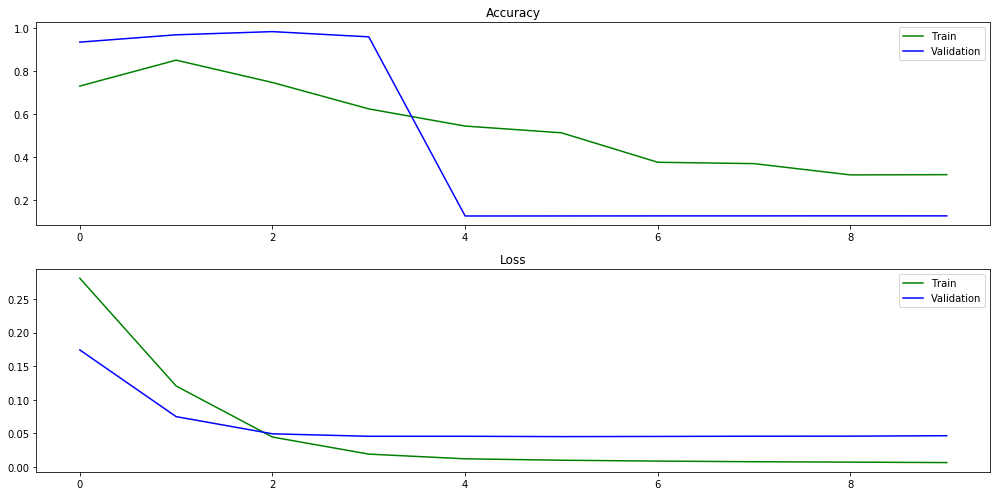

In [140]:
def plot(history):
    plt.subplot(211)
    plt.title("Accuracy")
    plt.plot(history.history["acc"], color="g", label="Train")
    plt.plot(history.history["val_acc"], color="b", label="Validation")
    plt.legend(loc="best")

    plt.subplot(212)
    plt.title("Loss")
    plt.plot(history.history["loss"], color="g", label="Train")
    plt.plot(history.history["val_loss"], color="b", label="Validation")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

plot(history_SimpleRNN)

Сразу с первой эпохи сеть показывает высокие результаты предсказаний, начиная с третей эпохи модель переобучается

Обучаем модель на одной эпохе

In [89]:
history_SimpleRNN = model_SimpleRNN.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                    epochs=1,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/1
5600/5600 [==============================] - 35s 6ms/step - loss: 0.2711 - acc: 0.7401 - val_loss: 0.1684 - val_acc: 0.9453


In [141]:
model_SimpleRNN.save('SimpleRNN.h5')

### LSTM

In [127]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_LSTM.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_LSTM.add(Dense(len(all_POStags)))
model_LSTM.add(Activation("softmax"))

model_LSTM.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [128]:
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 120, 128)          3492224   
_________________________________________________________________
lstm_5 (LSTM)                (None, 120, 64)           49408     
_________________________________________________________________
dense_8 (Dense)              (None, 120, 18)           1170      
_________________________________________________________________
activation_8 (Activation)    (None, 120, 18)           0         
Total params: 3,542,802
Trainable params: 3,542,802
Non-trainable params: 0
_________________________________________________________________


In [145]:
history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 67s 12ms/step - loss: 0.0873 - acc: 0.7949 - val_loss: 0.0592 - val_acc: 0.9314
Epoch 2/10
5600/5600 [==============================] - 68s 12ms/step - loss: 0.0271 - acc: 0.8537 - val_loss: 0.0463 - val_acc: 0.9419
Epoch 3/10
5600/5600 [==============================] - 76s 14ms/step - loss: 0.0136 - acc: 0.8396 - val_loss: 0.0438 - val_acc: 0.9422
Epoch 4/10
5600/5600 [==============================] - 83s 15ms/step - loss: 0.0105 - acc: 0.6942 - val_loss: 0.0433 - val_acc: 0.1258
Epoch 5/10
5600/5600 [==============================] - 74s 13ms/step - loss: 0.0090 - acc: 0.5474 - val_loss: 0.0435 - val_acc: 0.9421
Epoch 6/10
5600/5600 [==============================] - 69s 12ms/step - loss: 0.0080 - acc: 0.6905 - val_loss: 0.0435 - val_acc: 0.9336
Epoch 7/10
5600/5600 [==============================] - 69s 12ms/step - loss: 0.0072 - acc: 0.7236 - val_loss: 0.0438 - val_acc: 0.9424


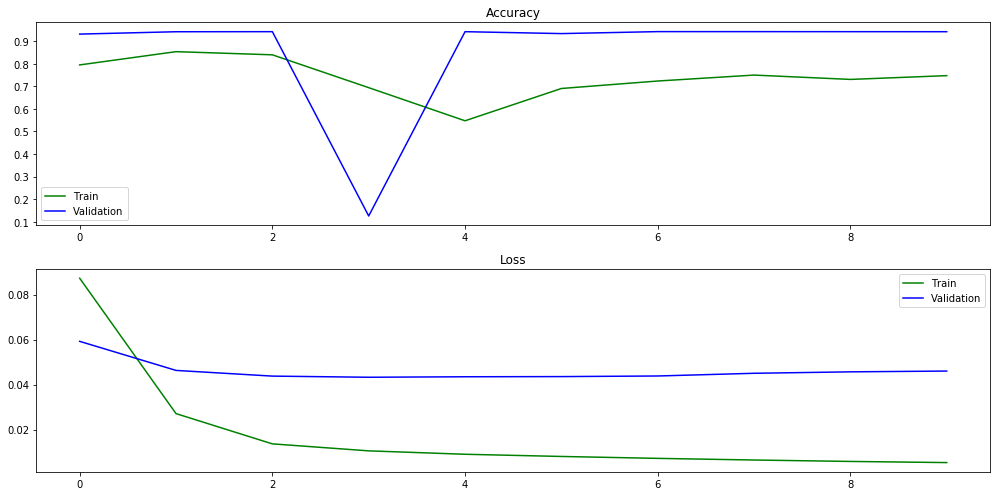

In [146]:
plot(history_LSTM)

In [129]:
history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=1,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/1
5600/5600 [==============================] - 66s 12ms/step - loss: 0.2631 - acc: 0.8439 - val_loss: 0.1462 - val_acc: 0.8623


In [130]:
model_LSTM.save('LSTM.h5')

In [131]:
# Оценка модели на тестовой выборке

score, acc = model_LSTM.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

1400/1400 [==============================] - 5s 3ms/step
Test score: 0.417, accuracy: 0.781


### Bidirectional LSTM

In [149]:
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_BiLSTM.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_BiLSTM.add(Dense(len(all_POStags)))
model_BiLSTM.add(Activation("softmax"))

model_BiLSTM.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [150]:
model_BiLSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 120, 128)          3492224   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 128)          98816     
_________________________________________________________________
dense_11 (Dense)             (None, 120, 18)           2322      
_________________________________________________________________
activation_11 (Activation)   (None, 120, 18)           0         
Total params: 3,593,362
Trainable params: 3,593,362
Non-trainable params: 0
_________________________________________________________________


In [151]:
history_LSTM = model_BiLSTM.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/5
5600/5600 [==============================] - 103s 18ms/step - loss: 0.2382 - acc: 0.8102 - val_loss: 0.1057 - val_acc: 0.7874
Epoch 2/5
5600/5600 [==============================] - 99s 18ms/step - loss: 0.0616 - acc: 0.2392 - val_loss: 0.0471 - val_acc: 0.1267
Epoch 3/5
5600/5600 [==============================] - 99s 18ms/step - loss: 0.0181 - acc: 0.1433 - val_loss: 0.0405 - val_acc: 0.1277
Epoch 4/5
5600/5600 [==============================] - 92s 16ms/step - loss: 0.0097 - acc: 0.3947 - val_loss: 0.0394 - val_acc: 0.8790
Epoch 5/5
5600/5600 [==============================] - 97s 17ms/step - loss: 0.0074 - acc: 0.6230 - val_loss: 0.0403 - val_acc: 0.9391


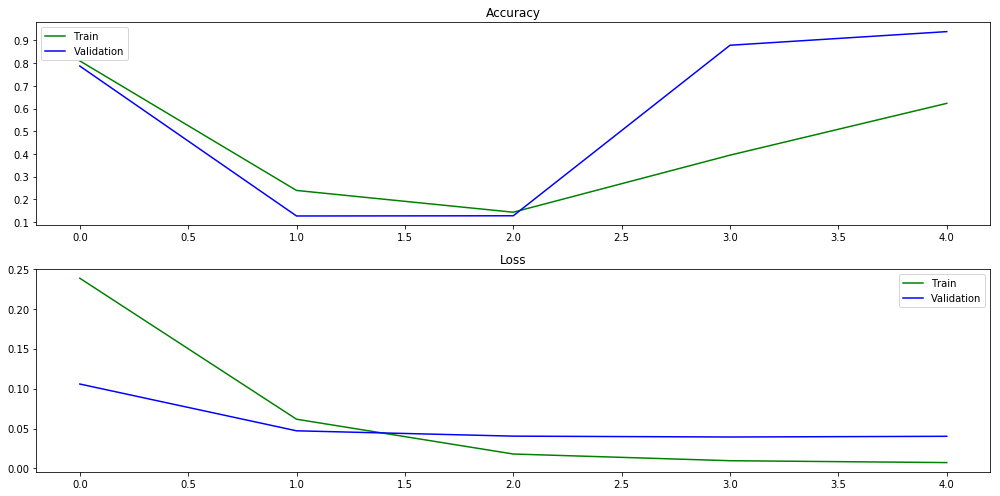

In [152]:
plot(history_LSTM)

Согласно графику, переобучение происходит на первой же эпохе

In [149]:
history_LSTM = model_BiLSTM.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 69s 17ms/step - loss: 0.2905 - acc: 0.8351 - val_loss: 0.1616 - val_acc: 0.9195


In [151]:
# Оценка модели на тестовой выборке

score, acc = model_BiLSTM.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

1000/1000 [==============================] - 3s 3ms/step
Test score: 0.162, accuracy: 0.919


### GRU

In [157]:
model_GRU = Sequential()
model_GRU.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_GRU.add(GRU(HIDDEN_LAYER_SIZE, return_sequences=True))
model_GRU.add(Dense(len(all_POStags)))
model_GRU.add(Activation("softmax"))

model_GRU.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [158]:
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 120, 128)          3492224   
_________________________________________________________________
gru_3 (GRU)                  (None, 120, 64)           37056     
_________________________________________________________________
dense_13 (Dense)             (None, 120, 18)           1170      
_________________________________________________________________
activation_13 (Activation)   (None, 120, 18)           0         
Total params: 3,530,450
Trainable params: 3,530,450
Non-trainable params: 0
_________________________________________________________________


In [159]:
history_GRU = model_GRU.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/5
5600/5600 [==============================] - 68s 12ms/step - loss: 0.2253 - acc: 0.4375 - val_loss: 0.0989 - val_acc: 0.1105
Epoch 2/5
5600/5600 [==============================] - 63s 11ms/step - loss: 0.0534 - acc: 0.1288 - val_loss: 0.0483 - val_acc: 0.1251
Epoch 3/5
5600/5600 [==============================] - 70s 12ms/step - loss: 0.0159 - acc: 0.1390 - val_loss: 0.0433 - val_acc: 0.1258
Epoch 4/5
5600/5600 [==============================] - 67s 12ms/step - loss: 0.0097 - acc: 0.1401 - val_loss: 0.0426 - val_acc: 0.1261
Epoch 5/5
5600/5600 [==============================] - 71s 13ms/step - loss: 0.0077 - acc: 0.3194 - val_loss: 0.0432 - val_acc: 0.8094


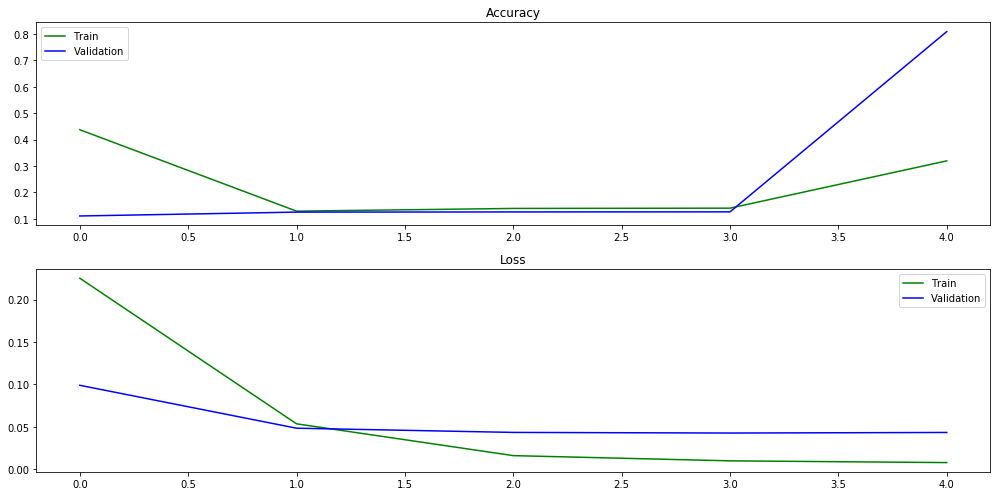

In [160]:
plot(history_GRU)

Точность модели возрастает на 5й эпохе

In [122]:
history_GRU = model_GRU.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 49s 12ms/step - loss: 0.2798 - acc: 0.8631 - val_loss: 0.1484 - val_acc: 0.9134


In [124]:
# Оценка модели на тестовой выборке

score, acc = model_GRU.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

1000/1000 [==============================] - 3s 3ms/step
Test score: 0.148, accuracy: 0.913


In [125]:
model_GRU.save('GRU.h5')

Таким образом, все рассмотренные нейронные сети показали хороший результат для задачи частеречной разметки слов 
Лучше себя показала двунаправленная LSTM с точностью на тестовой выборке 0.919, так как принцип её работы позволяет оценить связи между словамит - как в левом, так и правом контекстах. Почти такой же результат точности получила GRU (0.913), обычная LSTM - 0.781

## Изменение числа пространства Embedding’a

In [161]:
EMBEDDING_SIZE = 256

In [163]:
model_SimpleRNN_embed256 = Sequential()
model_SimpleRNN_embed256.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_SimpleRNN_embed256.add(SimpleRNN(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_SimpleRNN_embed256.add(Dense(len(all_POStags)))
model_SimpleRNN_embed256.add(Activation("softmax"))

model_SimpleRNN_embed256.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [164]:
history_SimpleRNN_embed256 = model_SimpleRNN_embed256.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/5
5600/5600 [==============================] - 47s 8ms/step - loss: 0.2505 - acc: 0.8773 - val_loss: 0.1362 - val_acc: 0.9556
Epoch 2/5
5600/5600 [==============================] - 42s 8ms/step - loss: 0.0867 - acc: 0.9744 - val_loss: 0.0577 - val_acc: 0.9816
Epoch 3/5
5600/5600 [==============================] - 43s 8ms/step - loss: 0.0273 - acc: 0.9937 - val_loss: 0.0454 - val_acc: 0.9838
Epoch 4/5
5600/5600 [==============================] - 44s 8ms/step - loss: 0.0134 - acc: 0.9962 - val_loss: 0.0438 - val_acc: 0.9841
Epoch 5/5
5600/5600 [==============================] - 42s 7ms/step - loss: 0.0102 - acc: 0.9962 - val_loss: 0.0435 - val_acc: 0.9842


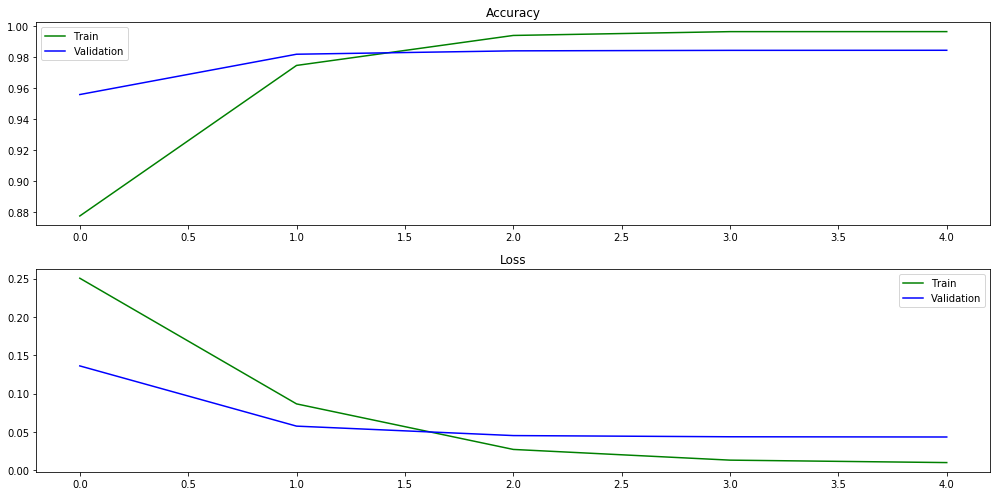

In [165]:
plot(history_SimpleRNN_embed256)

In [166]:
model_BiLSTM_embed256 = Sequential()
model_BiLSTM_embed256.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_BiLSTM_embed256.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_BiLSTM_embed256.add(Dense(len(all_POStags)))
model_BiLSTM_embed256.add(Activation("softmax"))

model_BiLSTM_embed256.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [167]:
history_LSTM_embed256 = model_BiLSTM_embed256.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/5
5600/5600 [==============================] - 115s 21ms/step - loss: 0.2136 - acc: 0.5241 - val_loss: 0.0858 - val_acc: 0.1152
Epoch 2/5
5600/5600 [==============================] - 114s 20ms/step - loss: 0.0451 - acc: 0.1360 - val_loss: 0.0422 - val_acc: 0.1275
Epoch 3/5
5600/5600 [==============================] - 107s 19ms/step - loss: 0.0123 - acc: 0.4291 - val_loss: 0.0392 - val_acc: 0.9598
Epoch 4/5
5600/5600 [==============================] - 113s 20ms/step - loss: 0.0080 - acc: 0.9788 - val_loss: 0.0392 - val_acc: 0.9861
Epoch 5/5
5600/5600 [==============================] - 116s 21ms/step - loss: 0.0060 - acc: 0.9976 - val_loss: 0.0401 - val_acc: 0.9860


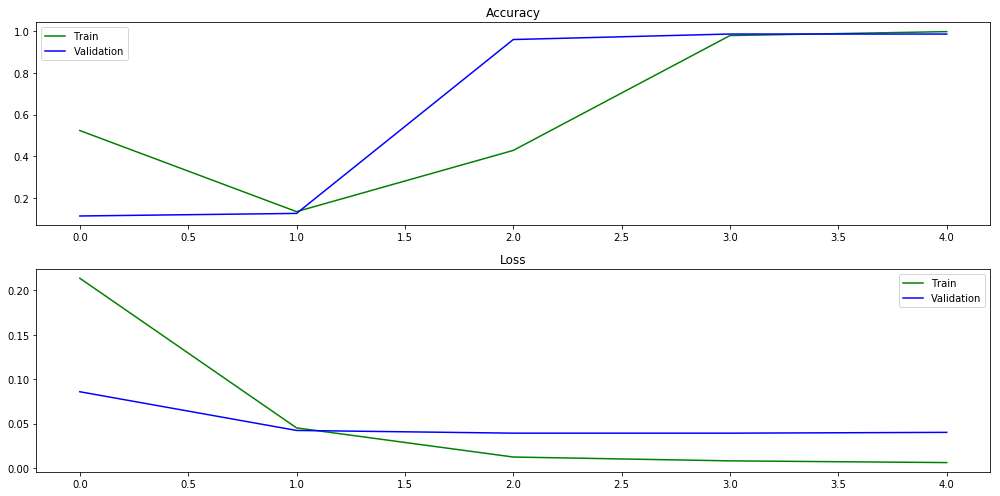

In [169]:
plot(history_LSTM_embed256)

In [170]:
model_GRU_embed256 = Sequential()
model_GRU_embed256.add(Embedding(len(all_train_words), EMBEDDING_SIZE, input_length=MAX_SEQLEN))
model_GRU_embed256.add(GRU(HIDDEN_LAYER_SIZE, return_sequences=True))
model_GRU_embed256.add(Dense(len(all_POStags)))
model_GRU_embed256.add(Activation("softmax"))

model_GRU_embed256.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [171]:
history_GRU = model_GRU_embed256.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=[X_val, y_val])

Train on 5600 samples, validate on 1400 samples
Epoch 1/5
5600/5600 [==============================] - 81s 14ms/step - loss: 0.1981 - acc: 0.8771 - val_loss: 0.0769 - val_acc: 0.8588
Epoch 2/5
5600/5600 [==============================] - 76s 14ms/step - loss: 0.0369 - acc: 0.1614 - val_loss: 0.0443 - val_acc: 0.1256
Epoch 3/5
5600/5600 [==============================] - 77s 14ms/step - loss: 0.0115 - acc: 0.5937 - val_loss: 0.0426 - val_acc: 0.9092
Epoch 4/5
5600/5600 [==============================] - 76s 14ms/step - loss: 0.0086 - acc: 0.9308 - val_loss: 0.0427 - val_acc: 0.9090
Epoch 5/5
5600/5600 [==============================] - 78s 14ms/step - loss: 0.0070 - acc: 0.9363 - val_loss: 0.0427 - val_acc: 0.9343


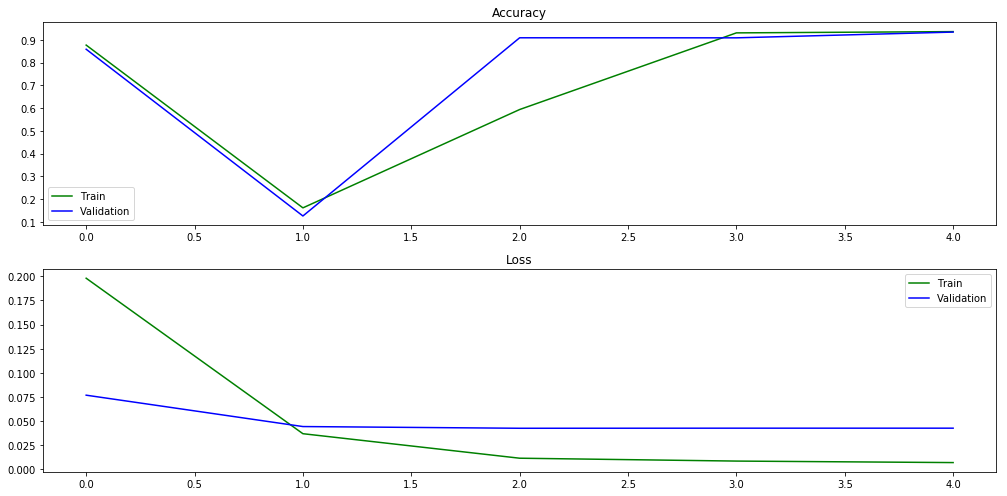

In [172]:
plot(history_GRU)

Таким образом, при увеличении количества слоя эмбединга все рассматриваемые типы рекуррентных нейронных сетей улучшили свою  предсказательную способность, что отражается в увеличении точности их предсказания:
SimpleRNN - c 0.9835 до 0.9842
BiLSTM - с 0.9391 до 0.9861
GRU - с 0.8094 до 0.9343